In [1]:
# Basic config (used by PyTorch pipeline)
import matplotlib.pyplot as plt
import numpy as np

data = 'plantvillage dataset/segmented'
BATCHSIZE = 32
IMAGE_SIZE = 224
EPOCHS = 20

In [2]:
# PyTorch: imports and device setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter

print(torch.__version__, torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Using CUDA:', torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True
else:
    print('CUDA not available, using CPU')


2.6.0+cu124 True
Using CUDA: NVIDIA GeForce RTX 4050 Laptop GPU


<h1>Segmented Model</h1>

In [3]:
# PyTorch: datasets and dataloaders
from sklearn.model_selection import train_test_split
from pathlib import Path

root = Path(data)

train_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

full_ds = datasets.ImageFolder(root=root)
class_to_idx = full_ds.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
NUM_CLASSES_PT = len(class_to_idx)
print('Classes:', NUM_CLASSES_PT)

indices = list(range(len(full_ds)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=123, stratify=[full_ds[i][1] for i in indices])

train_subset = Subset(full_ds, train_idx)
val_subset = Subset(full_ds, val_idx)

# Wrap subsets to apply transforms
train_subset.dataset.transform = train_tfms
val_subset.dataset.transform = val_tfms

train_loader = DataLoader(train_subset, batch_size=BATCHSIZE, shuffle=True, num_workers=4, pin_memory=(device.type=='cuda'))
val_loader = DataLoader(val_subset, batch_size=BATCHSIZE, shuffle=False, num_workers=4, pin_memory=(device.type=='cuda'))


Classes: 38


In [4]:
# PyTorch: model
model_pt = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
# Replace classifier
in_features = model_pt.classifier[1].in_features
model_pt.classifier[1] = nn.Linear(in_features, NUM_CLASSES_PT)
model_pt = model_pt.to(device)

# Optimizer, loss, scaler
criterion = nn.CrossEntropyLoss()
optimizer_pt = optim.AdamW(model_pt.parameters(), lr=1e-3, weight_decay=1e-4)
# Use new torch.amp API for scaler
from torch import amp as torch_amp
scaler = torch_amp.GradScaler('cuda') if device.type == 'cuda' else torch_amp.GradScaler(enabled=False)


In [ ]:
# PyTorch: training loop with AMP and checkpointing
from time import time
best_val_acc = 0.0
writer = SummaryWriter(log_dir='logs_pt')

EPOCHS_PT = EPOCHS

for epoch in range(EPOCHS_PT):
    model_pt.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, targets in train_loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer_pt.zero_grad(set_to_none=True)
        with torch_amp.autocast('cuda', enabled=(device.type=='cuda')):
            outputs = model_pt(images)
            loss = criterion(outputs, targets)
        scaler.scale(loss).backward()
        scaler.step(optimizer_pt)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += preds.eq(targets).sum().item()
        total += images.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    # Validation
    model_pt.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            with torch_amp.autocast('cuda', enabled=(device.type=='cuda')):
                outputs = model_pt(images)
                loss = criterion(outputs, targets)
            val_loss_sum += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            val_correct += preds.eq(targets).sum().item()
            val_total += images.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS_PT} - train_loss: {train_loss:.4f} acc: {train_acc:.4f} - val_loss: {val_loss:.4f} acc: {val_acc:.4f}")

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Acc/train', train_acc, epoch)
    writer.add_scalar('Acc/val', val_acc, epoch)

    # Checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model_pt.state_dict(),
            'optimizer_state_dict': optimizer_pt.state_dict(),
            'val_acc': val_acc,
            'class_to_idx': class_to_idx
        }, 'plant_segmented_model.pth')
        print('Saved new best checkpoint with val_acc:', best_val_acc)

writer.close()


Epoch 1/20 - train_loss: 0.3261 acc: 0.8995 - val_loss: 0.1373 acc: 0.9548
Saved new best checkpoint with val_acc: 0.95479653839072
Epoch 2/20 - train_loss: 0.1662 acc: 0.9454 - val_loss: 0.1301 acc: 0.9566
Saved new best checkpoint with val_acc: 0.9566378199226662
Epoch 3/20 - train_loss: 0.1308 acc: 0.9578 - val_loss: 0.1895 acc: 0.9434
Epoch 4/20 - train_loss: 0.1190 acc: 0.9619 - val_loss: 0.0643 acc: 0.9804
Saved new best checkpoint with val_acc: 0.9803903516847726
Epoch 5/20 - train_loss: 0.0941 acc: 0.9706 - val_loss: 0.0727 acc: 0.9771
Epoch 6/20 - train_loss: 0.0871 acc: 0.9714 - val_loss: 0.0960 acc: 0.9719
Epoch 7/20 - train_loss: 0.0778 acc: 0.9747 - val_loss: 0.0928 acc: 0.9714
Epoch 8/20 - train_loss: 0.0735 acc: 0.9761 - val_loss: 0.1006 acc: 0.9696
Epoch 9/20 - train_loss: 0.0632 acc: 0.9793 - val_loss: 0.0814 acc: 0.9762
Epoch 10/20 - train_loss: 0.0618 acc: 0.9801 - val_loss: 0.0715 acc: 0.9769
Epoch 11/20 - train_loss: 0.0610 acc: 0.9806 - val_loss: 0.0672 acc: 0.982

In [5]:
# Rename any existing old checkpoint filename on disk (optional)
import os
old_ckpt = 'plant_mobilenetv2_pt_best.pth'
new_ckpt = 'plant_segmented_model.pth'
if os.path.exists(old_ckpt) and not os.path.exists(new_ckpt):
    os.replace(old_ckpt, new_ckpt)
    print(f"Renamed {old_ckpt} -> {new_ckpt}")
else:
    print("No rename needed.")


No rename needed.


In [6]:
# PyTorch: final evaluation on validation set
model_pt.eval()
val_loss_sum, val_correct, val_total = 0.0, 0, 0
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        with autocast(enabled=(device.type=='cuda')):
            outputs = model_pt(images)
            loss = criterion(outputs, targets)
        val_loss_sum += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        val_correct += preds.eq(targets).sum().item()
        val_total += images.size(0)

val_loss = val_loss_sum / val_total
val_acc = val_correct / val_total
print(f"Validation - loss: {val_loss:.4f}, acc: {val_acc:.4f}")


C:\Users\ilias\AppData\Local\Temp\ipykernel_20084\1680082665.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type=='cuda')):


Validation - loss: 3.6946, acc: 0.0165


In [7]:
# Utils: dataset/model builders and train/eval with AMP
from sklearn.metrics import classification_report
from torch import amp as torch_amp
from copy import deepcopy

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


def build_loaders(root_path: str, image_size: int, batch_size: int, grayscale: bool, device: torch.device):
    tfms = []
    if grayscale:
        tfms.append(transforms.Grayscale(num_output_channels=3))
    tfms.extend([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    train_tfms = transforms.Compose(tfms)

    val_tfms_list = []
    if grayscale:
        val_tfms_list.append(transforms.Grayscale(num_output_channels=3))
    val_tfms_list.extend([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])
    val_tfms = transforms.Compose(val_tfms_list)

    ds_full = datasets.ImageFolder(root=root_path)
    class_to_idx = ds_full.class_to_idx
    indices = list(range(len(ds_full)))
    labels = [ds_full[i][1] for i in indices]
    train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=123, stratify=labels)

    ds_train = Subset(ds_full, train_idx)
    ds_val = Subset(ds_full, val_idx)
    ds_train.dataset.transform = train_tfms
    ds_val.dataset.transform = val_tfms

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=(device.type=='cuda'))
    loader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=(device.type=='cuda'))

    return loader_train, loader_val, class_to_idx


def build_model(num_classes: int, device: torch.device):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scaler = torch_amp.GradScaler('cuda') if device.type == 'cuda' else torch_amp.GradScaler(enabled=False)
    return model, optimizer, criterion, scaler


def train_model(model, optimizer, criterion, scaler, train_loader, val_loader, epochs: int, device: torch.device, ckpt_path: str, log_dir: str):
    writer = SummaryWriter(log_dir=log_dir)
    best_val_acc = 0.0
    history = { 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
        for images, targets in train_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch_amp.autocast('cuda', enabled=(device.type=='cuda')):
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            running_correct += preds.eq(targets).sum().item()
            total += images.size(0)

        train_loss = running_loss / total if total else 0.0
        train_acc = running_correct / total if total else 0.0

        # validation
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)
                with torch_amp.autocast('cuda', enabled=(device.type=='cuda')):
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                val_loss_sum += loss.item() * images.size(0)
                _, preds = outputs.max(1)
                val_correct += preds.eq(targets).sum().item()
                val_total += images.size(0)
        val_loss = val_loss_sum / val_total if val_total else 0.0
        val_acc = val_correct / val_total if val_total else 0.0

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Acc/train', train_acc, epoch)
        writer.add_scalar('Acc/val', val_acc, epoch)

        print(f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.4f} acc: {train_acc:.4f} - val_loss: {val_loss:.4f} acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, ckpt_path)
            print('Saved new best:', ckpt_path, 'val_acc:', best_val_acc)

    writer.close()
    return history


def evaluate_model(model, val_loader, device: torch.device):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = model(images)
            _, preds = outputs.max(1)
            y_true.extend(targets.detach().cpu().tolist())
            y_pred.extend(preds.detach().cpu().tolist())
    return y_true, y_pred


In [8]:
# Train: segmented
seg_train, seg_val, seg_class_to_idx = build_loaders('plantvillage dataset/segmented', IMAGE_SIZE, BATCHSIZE, grayscale=False, device=device)
num_classes_seg = len(seg_class_to_idx)
model_seg, opt_seg, crit_seg, scaler_seg =    build_model(num_classes_seg, device)
hist_seg = train_model(model_seg, opt_seg, crit_seg, scaler_seg, seg_train, seg_val, EPOCHS, device, 'plant_segmented_model.pth', 'logs_pt_segmented')

Epoch 1/20 - train_loss: 0.3273 acc: 0.8990 - val_loss: 0.1562 acc: 0.9478
Saved new best: plant_segmented_model.pth val_acc: 0.9477996685693243
Epoch 2/20 - train_loss: 0.1653 acc: 0.9464 - val_loss: 0.1128 acc: 0.9643
Saved new best: plant_segmented_model.pth val_acc: 0.964279138280243
Epoch 3/20 - train_loss: 0.1307 acc: 0.9572 - val_loss: 0.1044 acc: 0.9670
Saved new best: plant_segmented_model.pth val_acc: 0.9670410605781624
Epoch 4/20 - train_loss: 0.1138 acc: 0.9637 - val_loss: 0.0792 acc: 0.9765
Saved new best: plant_segmented_model.pth val_acc: 0.9765236604676855
Epoch 5/20 - train_loss: 0.1005 acc: 0.9683 - val_loss: 0.1402 acc: 0.9569
Epoch 6/20 - train_loss: 0.0859 acc: 0.9726 - val_loss: 0.0781 acc: 0.9762
Epoch 7/20 - train_loss: 0.0817 acc: 0.9737 - val_loss: 0.0853 acc: 0.9724
Epoch 8/20 - train_loss: 0.0747 acc: 0.9746 - val_loss: 0.0526 acc: 0.9812
Saved new best: plant_segmented_model.pth val_acc: 0.9812189283741484
Epoch 9/20 - train_loss: 0.0603 acc: 0.9798 - val_l

In [9]:
# Train: grayscale
gray_train, gray_val, gray_class_to_idx = build_loaders('plantvillage dataset/grayscale', IMAGE_SIZE, BATCHSIZE, grayscale=True, device=device)
num_classes_gray = len(gray_class_to_idx)
model_gray, opt_gray, crit_gray, scaler_gray = build_model(num_classes_gray, device)
hist_gray = train_model(model_gray, opt_gray, crit_gray, scaler_gray, gray_train, gray_val, EPOCHS, device, 'plant_grayscale_model.pth', 'logs_pt_grayscale')


Epoch 1/20 - train_loss: 0.4631 acc: 0.8538 - val_loss: 0.2645 acc: 0.9159
Saved new best: plant_grayscale_model.pth val_acc: 0.9159377589540558
Epoch 2/20 - train_loss: 0.2467 acc: 0.9187 - val_loss: 0.3389 acc: 0.8998
Epoch 3/20 - train_loss: 0.1876 acc: 0.9381 - val_loss: 0.2102 acc: 0.9289
Saved new best: plant_grayscale_model.pth val_acc: 0.9289199889512936
Epoch 4/20 - train_loss: 0.1655 acc: 0.9440 - val_loss: 0.1223 acc: 0.9588
Saved new best: plant_grayscale_model.pth val_acc: 0.958751496178989
Epoch 5/20 - train_loss: 0.1475 acc: 0.9500 - val_loss: 0.1872 acc: 0.9449
Epoch 6/20 - train_loss: 0.1336 acc: 0.9553 - val_loss: 0.1653 acc: 0.9493
Epoch 7/20 - train_loss: 0.1187 acc: 0.9601 - val_loss: 0.1243 acc: 0.9627
Saved new best: plant_grayscale_model.pth val_acc: 0.9627106159653808
Epoch 8/20 - train_loss: 0.1069 acc: 0.9632 - val_loss: 0.0902 acc: 0.9701
Saved new best: plant_grayscale_model.pth val_acc: 0.9700764202191327
Epoch 9/20 - train_loss: 0.0986 acc: 0.9660 - val_l

In [10]:
# Train: color
color_train, color_val, color_class_to_idx = build_loaders('plantvillage dataset/color', IMAGE_SIZE, BATCHSIZE, grayscale=False, device=device)
num_classes_color = len(color_class_to_idx)
model_color, opt_color, crit_color, scaler_color = build_model(num_classes_color, device)
hist_color = train_model(model_color, opt_color, crit_color, scaler_color, color_train, color_val, EPOCHS, device, 'plant_color_model.pth', 'logs_pt_color')


Epoch 1/20 - train_loss: 0.2857 acc: 0.9119 - val_loss: 0.1556 acc: 0.9460
Saved new best: plant_color_model.pth val_acc: 0.946045483841267
Epoch 2/20 - train_loss: 0.1322 acc: 0.9584 - val_loss: 0.1054 acc: 0.9671
Saved new best: plant_color_model.pth val_acc: 0.9671300985176319
Epoch 3/20 - train_loss: 0.1034 acc: 0.9671 - val_loss: 0.0907 acc: 0.9704
Saved new best: plant_color_model.pth val_acc: 0.9703526378786483
Epoch 4/20 - train_loss: 0.0900 acc: 0.9699 - val_loss: 0.0880 acc: 0.9730
Saved new best: plant_color_model.pth val_acc: 0.9730227419206334
Epoch 5/20 - train_loss: 0.0798 acc: 0.9748 - val_loss: 0.0777 acc: 0.9749
Saved new best: plant_color_model.pth val_acc: 0.9748641929840715
Epoch 6/20 - train_loss: 0.0745 acc: 0.9763 - val_loss: 0.1546 acc: 0.9564
Epoch 7/20 - train_loss: 0.0647 acc: 0.9792 - val_loss: 0.0554 acc: 0.9838
Saved new best: plant_color_model.pth val_acc: 0.9837952306417457
Epoch 8/20 - train_loss: 0.0579 acc: 0.9815 - val_loss: 0.0393 acc: 0.9870
Saved

In [11]:
# Reports: classification_report for each validation set
from sklearn.metrics import classification_report

def report_for(model, val_loader, classes):
    y_true, y_pred = evaluate_model(model, val_loader, device)
    print(classification_report(y_true, y_pred, target_names=classes))

print('=== Segmented report ===')
seg_classes = [k for k,_ in sorted(seg_class_to_idx.items(), key=lambda kv: kv[1])]
report_for(model_seg, seg_val, seg_classes)

print('=== Grayscale report ===')
gray_classes = [k for k,_ in sorted(gray_class_to_idx.items(), key=lambda kv: kv[1])]
report_for(model_gray, gray_val, gray_classes)

print('=== Color report ===')
color_classes = [k for k,_ in sorted(color_class_to_idx.items(), key=lambda kv: kv[1])]
report_for(model_color, color_val, color_classes)


=== Segmented report ===
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.99      0.98      0.98       126
                                 Apple___Black_rot       0.99      1.00      1.00       124
                          Apple___Cedar_apple_rust       0.96      0.96      0.96        55
                                   Apple___healthy       0.99      0.99      0.99       329
                               Blueberry___healthy       1.00      0.99      1.00       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       0.98      0.99      0.99       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.89      0.90       103
                       Corn_(maize)___Common_rust_       0.98      0.99      0.99       238
               Corn_(maize)___Northern_Leaf_Blight    

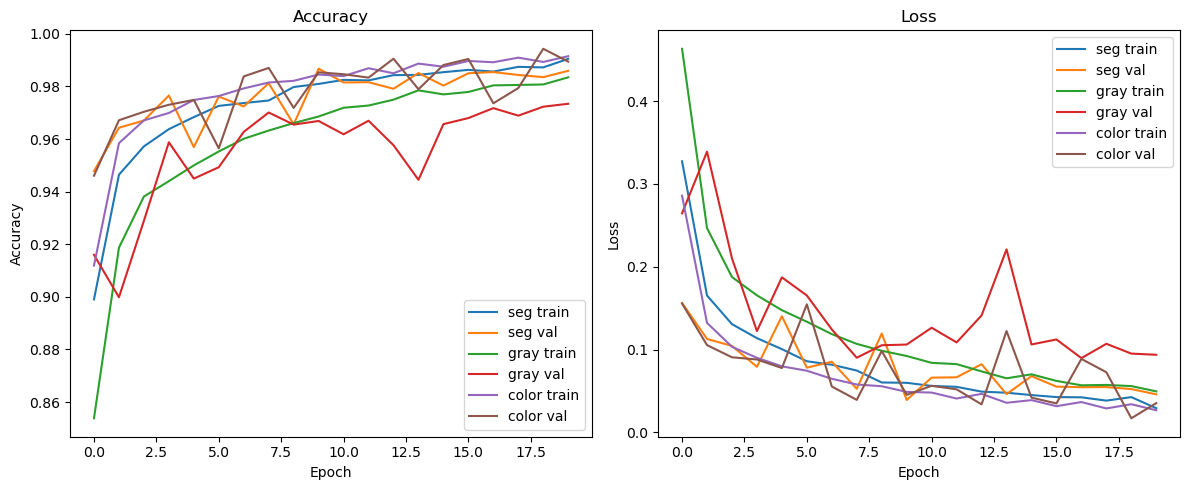

In [12]:
# Comparative plots of accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist_seg['train_acc'], label='seg train')
plt.plot(hist_seg['val_acc'], label='seg val')
plt.plot(hist_gray['train_acc'], label='gray train')
plt.plot(hist_gray['val_acc'], label='gray val')
plt.plot(hist_color['train_acc'], label='color train')
plt.plot(hist_color['val_acc'], label='color val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_seg['train_loss'], label='seg train')
plt.plot(hist_seg['val_loss'], label='seg val')
plt.plot(hist_gray['train_loss'], label='gray train')
plt.plot(hist_gray['val_loss'], label='gray val')
plt.plot(hist_color['train_loss'], label='color train')
plt.plot(hist_color['val_loss'], label='color val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
